In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import svm

In [2]:
df = pd.read_csv("all_data.csv", encoding='utf-8')

### PCA Analysis

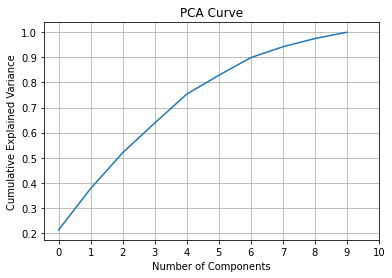

In [53]:
# Select columns to run pca with
X = df[[ 'education',  'state_legislature',
       'state_gov', 'life_exp_f_m',
       'labour_force_participation',
       'bachelor_wage_gap', 'ab_legality',
       'ab_rate', 'year'
       ]]
y = df['rape_rate']  
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Build PCA model
pca = PCA().fit(X)

# Plot PCA curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 11, 1))
plt.title('PCA Curve')
plt.grid()
plt.show()

Thus, we choose cumulative explained variance (CEV) = 0.9 as the cutoff. When CEV is 0.9, PCA shows the number of component 6, which means 90% of the total variance in the dataset is explained by the retained principal components. 

##### Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [45]:
def calc_r2(model_type):
    ''' Apply different models and calculate r2, adjusted r2 for each model. '''
    model = model_type
    model.fit(X_train, y_train)
    r2 = model.best_estimator_.score(X_test, y_test)
    print('Best params: ', model.best_params_)
    print('r2: ', round(r2, 3))
    n = len(y_test)
    k = X_test.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    print('adjusted_r2: ', round(adj_r2, 3))

### Linear Regression

##### Linear Regression without PCA

In [46]:
lr_model = LinearRegression()
param_grid_lr = {
    'fit_intercept': [True, False]
    }

lr = GridSearchCV(lr_model, param_grid_lr, cv=5, n_jobs=-1)
calc_r2(lr)

Best params:  {'fit_intercept': True}
r2:  0.385
adjusted_r2:  0.341


##### Linear Regression with PCA

In [47]:
pipe_lr_pca = Pipeline(steps=[('pca', PCA(n_components=6)),
                        ('regressor', LinearRegression())])
param_grid_lr_pca = {
    'regressor__fit_intercept': [True, False]
    }

lr_pca = GridSearchCV(pipe_lr_pca, param_grid_lr_pca, cv=5, n_jobs=-1)
calc_r2(lr_pca)

Best params:  {'regressor__fit_intercept': True}
r2:  0.37
adjusted_r2:  0.324


We only used PCA with linear regression model because PCA is a linear technique that assumes the predictors and target have a linear relationship. 

Linear regression without PCA performs better than linear regression with PCA may due to information loss, overfitting in the linear regression, or the amplification of noise in the data by PCA.

### Random Forest Regressor

In [48]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
param_grid_rf = {
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': [2, 3, 4, 5],
    'bootstrap': [True, False]
    }

rf = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1)
calc_r2(rf)

Best params:  {'bootstrap': True, 'criterion': 'squared_error', 'min_samples_split': 2}
r2:  0.615
adjusted_r2:  0.587


### Ridge Regression

In [49]:
ridge_model = Ridge(random_state=42)
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'max_iter': [100, 500, 1000]
    }

ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5, n_jobs=-1)
calc_r2(ridge)

Best params:  {'alpha': 10.0, 'max_iter': 100, 'solver': 'lsqr'}
r2:  0.386
adjusted_r2:  0.341


### Lasso Regression

In [50]:
lasso_model = Lasso(random_state=42)
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0],
    'selection': ['cyclic', 'random'],
    'max_iter': [100, 500, 1000]
    }

lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, n_jobs=-1)
calc_r2(lasso)

Best params:  {'alpha': 0.1, 'max_iter': 100, 'selection': 'random'}
r2:  0.388
adjusted_r2:  0.344


### SVM Regression

In [51]:
svr_model = svm.SVR()
param_grid_svr = {
    'C': [0.1, 1.0, 10.0, 100],
    'epsilon': [0.01, 0.1, 1.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False]
}

svr = GridSearchCV(svr_model, param_grid_svr, cv=5, n_jobs=-1)
calc_r2(svr)

Best params:  {'C': 100, 'epsilon': 1.0, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': False}
r2:  0.604
adjusted_r2:  0.575


In [52]:
scores = {'Model': ['Linear Reg', 'Linear Reg w/ PCA', 'Random Forest', 'Ridge', 'Lasso', 'SVR'],
          'R2': [0.385, 0.37, 0.615, 0.386, 0.388, 0.604],
          'Adjusted R2': [0.341, 0.324, 0.587, 0.341, 0.344, 0.575]}
table = pd.DataFrame(scores)
table

,Model,R2,Adjusted R2
0,Linear Reg,0.385,0.341
1,Linear Reg w/ PCA,0.370,0.324
2,Random Forest,0.615,0.587
3,Ridge,0.386,0.341
4,Lasso,0.388,0.344
5,SVR,0.604,0.575


Human behavior analysis using ML models resulting in a low r2 score is not uncommon. Only using gender gap to predict rape rate can have a high r2 score of over 0.6, if we can incorporate more data such as regional police force, we may have an even better prediciton. 